### installing dependencies

In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch #working with tensors

###user inputs

In [89]:
#considering them as simple numeric values
G = 1.0
m1 = 1.0
m2 = 1.0
#I decide to give the masses equally opposite speeds and keeping them at symmetric positions w.r.t. x=0
#Initial positions vectors
x1_0 = torch.tensor([1.0, 0.0], dtype=torch.float32)
x2_0 = torch.tensor([-1.0, 0.0], dtype=torch.float32)

#Initial velocities vectors
v1_0 = torch.tensor([0.0, 0.5], dtype=torch.float32)
v2_0 = torch.tensor([0.0, -0.5], dtype=torch.float32)

# Prediction time
T = 5.0  #in seconds


### Data generation

In [90]:
#ground truth data for two-body ODE generated with physics solver_ivp
from scipy.integrate import solve_ivp

def two_body_ode(t, y, m1, m2):
    x1 = y[:2]
    v1 = y[2:4]
    x2 = y[4:6]
    v2 = y[6:8]
    r12 = np.linalg.norm(x2 - x1)
    a1 = G * m2 * (x2 - x1) / r12**3
    a2 = G * m1 * (x1 - x2) / r12**3
    return np.concatenate([v1, a1, v2, a2])
y0 = np.concatenate([x1_0, v1_0, x2_0, v2_0])
t_span = (0, T)
t_eval = np.linspace(0, T, 100)
sol = solve_ivp(two_body_ode, t_span, y0, t_eval=t_eval, args=(m1, m2))
# Ground truth trajectories
x1_true = sol.y[:2].T  # shape: (timesteps, 2)
x2_true = sol.y[4:6].T
t_data = sol.t.reshape(-1, 1)


In [91]:
# def generate_dataset(m1, m2, x1_0, v1_0, x2_0, v2_0, t_max=10.0, num_points=500):
#     y0 = np.concatenate([x1_0, v1_0, x2_0, v2_0])
#     t_eval = np.linspace(0, t_max, num_points)
#     sol = solve_ivp(fun=lambda t, y: two_body_ode(t, y, m1, m2),
#                     t_span=(0, t_max),
#                     y0=y0,
#                     t_eval=t_eval,
#                     method='RK45')

#     t_data = sol.t.reshape(-1, 1)  # shape (N, 1)
#     y_data = sol.y.T               # shape (N, 8)
#     return t_data, y_data


### Model Definition

In [94]:
#train the neural network as per universal approximation theorem
import torch.nn as nn
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 8)  # Output: x1, v1, x2, v2 (each 2D)
        )

    def forward(self, t):
      return self.net(t)
model = PINN()


In [95]:
# hyperparameter-tuning
l_ODEloss=1.0
l_dataloss=2.5

In [96]:
#optimize the parameters with learning rate =o.oo1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
t_train = torch.tensor(t_data, dtype=torch.float32, requires_grad=True)
x1_train = torch.tensor(x1_true, dtype=torch.float32)
x2_train = torch.tensor(x2_true, dtype=torch.float32)

def ode_residue(model, t, m1, m2):
    pred = model(t)
    x1, v1, x2, v2 = torch.split(pred, 2, dim=1)
#First derivatives (velocities)= dx/dt = v, so we get dV/dt = a
    a1 = torch.zeros_like(v1)
    a2 = torch.zeros_like(v2)
    for i in range(2):  # loop over x and y components
        grad_v1_i = torch.autograd.grad(v1[:, i], t, grad_outputs=torch.ones_like(v1[:, i]), create_graph=True)[0]
        grad_v2_i = torch.autograd.grad(v2[:, i], t, grad_outputs=torch.ones_like(v2[:, i]), create_graph=True)[0]
        a1[:, i] = grad_v1_i.squeeze()
        a2[:, i] = grad_v2_i.squeeze()

    #Compute true acceleration from Newton's law
    r = x2 - x1
    r_norm = torch.norm(r, dim=1, keepdim=True) + 1e-6
    a1_true = G * m2 * r / r_norm**3
    a2_true = -G * m1 * r / r_norm**3

    #Mean squared ODE residual
    return ((a1 - a1_true)**2).mean() + ((a2 - a2_true)**2).mean()



def loss_fn(model, t, x1_true, x2_true):
    pred = model(t)
    x1_pred, _, x2_pred, _ = torch.split(pred, 2, dim=1)
    data_loss = nn.MSELoss()(x1_pred, x1_true) + nn.MSELoss()(x2_pred, x2_true)
    ode_loss = ode_residue(model, t, m1, m2)
    return l_dataloss*data_loss + l_ODEloss*ode_loss, data_loss.item(), ode_loss.item()
for epoch in range(4000):
    optimizer.zero_grad()
    loss, data_loss, ode_loss = loss_fn(model, t_train, x1_train, x2_train)
    #back-propagation for optimizing the parameters
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}, Data Loss: {data_loss:.5f}, ODE Loss: {ode_loss:.5f}")


Epoch 0, Loss: 40.56048, Data Loss: 0.64815, ODE Loss: 38.94009
Epoch 200, Loss: 0.16472, Data Loss: 0.06454, ODE Loss: 0.00336
Epoch 400, Loss: 0.10386, Data Loss: 0.04126, ODE Loss: 0.00070
Epoch 600, Loss: 0.07203, Data Loss: 0.02849, ODE Loss: 0.00080
Epoch 800, Loss: 0.04643, Data Loss: 0.01836, ODE Loss: 0.00053
Epoch 1000, Loss: 0.02843, Data Loss: 0.01127, ODE Loss: 0.00024
Epoch 1200, Loss: 0.01733, Data Loss: 0.00686, ODE Loss: 0.00018
Epoch 1400, Loss: 0.01086, Data Loss: 0.00428, ODE Loss: 0.00016
Epoch 1600, Loss: 0.00709, Data Loss: 0.00278, ODE Loss: 0.00014
Epoch 1800, Loss: 0.00479, Data Loss: 0.00186, ODE Loss: 0.00013
Epoch 2000, Loss: 0.00332, Data Loss: 0.00128, ODE Loss: 0.00011
Epoch 2200, Loss: 0.00235, Data Loss: 0.00090, ODE Loss: 0.00009
Epoch 2400, Loss: 0.00169, Data Loss: 0.00065, ODE Loss: 0.00007
Epoch 2600, Loss: 0.00125, Data Loss: 0.00048, ODE Loss: 0.00005
Epoch 2800, Loss: 0.00094, Data Loss: 0.00036, ODE Loss: 0.00003
Epoch 3000, Loss: 0.00072, Dat

###Unseen Test Dataset

In [ ]:
# G = 1.0
# m1_test = 1.2
# m2_test = 0.9
# x1_0_test = np.array([-1.2, 0.2])
# x2_0_test = np.array([1.3, -0.1])
# v1_0_test = np.array([0.0, 0.6])
# v2_0_test = np.array([0.0, -0.4])
# T_test = 10.0
# num_points_test = 500
# t_eval_test = np.linspace(0, T_test, num_points_test)
# def two_body_ode(t, y, m1, m2):
#     x1 = y[:2]
#     v1 = y[2:4]
#     x2 = y[4:6]
#     v2 = y[6:8]
#     r12 = np.linalg.norm(x2 - x1)
#     a1 = G * m2 * (x2 - x1) / r12**3
#     a2 = G * m1 * (x1 - x2) / r12**3
#     return np.concatenate([v1, a1, v2, a2])
# y0_test = np.concatenate([x1_0_test, v1_0_test, x2_0_test, v2_0_test])
# sol_test = solve_ivp(
#     two_body_ode,
#     t_span=(0, T_test),
#     y0=y0_test,
#     t_eval=t_eval_test,
#     args=(m1_test, m2_test)
# )

# t_test = sol_test.t.reshape(-1, 1)
# y_test = sol_test.y.T
# x1_test = y_test[:, :2]
# x2_test = y_test[:, 4:6]

### Evaluation criteria

In [97]:
from sklearn.metrics import mean_absolute_error
with torch.no_grad():
    t_test = torch.tensor(t_data, dtype=torch.float32)
    pred = model(t_test)
    x1_pred, _, x2_pred, _ = torch.split(pred, 2, dim=1)
    mae_x1 = mean_absolute_error(x1_true, x1_pred.numpy())
    mae_x2 = mean_absolute_error(x2_true, x2_pred.numpy())
    print(f"MAE x1: {mae_x1:.5f}, MAE x2: {mae_x2:.5f}")


MAE x1: 0.00556, MAE x2: 0.00333


### Final model performance

In [98]:
# Example masses and initial conditions
# m1, m2 = 1.0, 1.0
# x1_0 = np.array([-0.5, 0.0])
# v1_0 = np.array([0.0, 1.0])
# x2_0 = np.array([0.5, 0.0])
# v2_0 = np.array([0.0, -1.0])
#  Generate test data
# t_test, y_test = generate_dataset(m1, m2, x1_0, v1_0, x2_0, v2_0, t_max=10.0, num_points=500)
#  Convert to PyTorch tensors
# t_test_tensor = torch.tensor(t_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


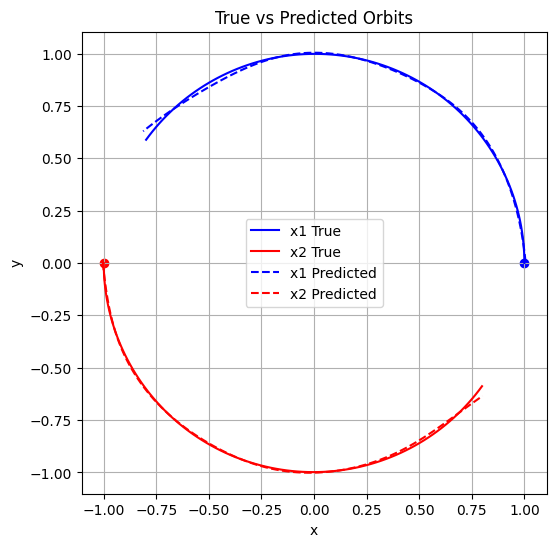

In [99]:
import matplotlib.pyplot as plt

def plot_orbits(x1_pred, x2_pred, x1_true, x2_true, title="True vs Predicted Orbits"):
    plt.figure(figsize=(6, 6))
    plt.plot(x1_true[:, 0], x1_true[:, 1], 'b-', label='x1 True')
    plt.plot(x2_true[:, 0], x2_true[:, 1], 'r-', label='x2 True')
    plt.plot(x1_pred[:, 0], x1_pred[:, 1], 'b--', label='x1 Predicted')
    plt.plot(x2_pred[:, 0], x2_pred[:, 1], 'r--', label='x2 Predicted')
    plt.scatter([x1_true[0, 0]], [x1_true[0, 1]], c='blue', marker='o')
    plt.scatter([x2_true[0, 0]], [x2_true[0, 1]], c='red', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()
# t_test_tensor: shape (N, 1)
# y_test_tensor: shape (N, 8)


# model.eval()
# with torch.no_grad():
#     y_pred = model(t_test_tensor)
#     x1_pred, _, x2_pred, _ = torch.split(y_pred, 2, dim=1)
#     x1_true = y_test_tensor[:, 0:2]
#     x2_true = y_test_tensor[:, 4:6]

#plot_orbits(x1_pred.cpu().numpy(), x2_pred.cpu().numpy(),
            #x1_true.cpu().numpy(), x2_true.cpu().numpy())

plot_orbits(x1_pred, x2_pred,
            x1_true, x2_true)


In [100]:
print(f"MAE x1: {mae_x1:.5f}")
print(f"MAE x2: {mae_x2:.5f}")


MAE x1: 0.00556
MAE x2: 0.00333
